<a href="https://colab.research.google.com/github/jwilliams2023/Machine-Learning-Assignments/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

- numpy
- pandas
- matplotlib
- seaborn
- scikit-learn
- nltk
- gensim
- datasets
- transformers
- torch
- evaluate


In [1]:
%pip install numpy pandas matplotlib seaborn scikit-learn nltk gensim datasets transformers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Part 1 Word Embeddings and N-gram

In [2]:
import gensim.downloader as api
from gensim.models import FastText
from gensim.test.utils import common_texts

print(common_texts[0])
print(len(common_texts[0]))

['human', 'interface', 'computer']
3


### 1. (a)

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd


In [4]:
words = ["Dog", "Bark", "Tree", "Bank", "River", "Money"]

In [5]:
def compute_similarity_matrix(model, words):
  vectors = []
  labels = []
  for word in words:
    key = word.lower()
    if key in model:
      vectors.append(model[key])
      labels.append(word)
    else:
      print(word, "not found in vocab")

  similarity_matrix = cosine_similarity(vectors)
  df = pd.DataFrame(similarity_matrix, index=labels, columns=labels)
  return df

In [6]:
if 'model' not in globals():
    model = api.load('glove-twitter-50')

In [7]:
similarity_matrix = compute_similarity_matrix(model, words)
display(similarity_matrix)

,Dog,Bark,Tree,Bank,River,Money
Dog,1.000000,0.593780,0.713751,0.348236,0.401201,0.575133
Bark,0.593780,1.000000,0.545873,0.040109,0.266635,0.290985
Tree,0.713751,0.545873,1.000000,0.349456,0.487116,0.510081
Bank,0.348236,0.040109,0.349456,1.000000,0.319922,0.674656
River,0.401201,0.266635,0.487116,0.319922,1.000000,0.337800
Money,0.575133,0.290985,0.510081,0.674656,0.337800,1.000000


### 1. (b)

In [8]:
fasttext_model = FastText(sentences=common_texts, vector_size=50, window=5, min_count=1, epochs=10)
fasttext_similarity_matrix = compute_similarity_matrix(fasttext_model.wv,words)
display(fasttext_similarity_matrix)

,Dog,Bark,Tree,Bank,River,Money
Dog,1.000000,0.107832,-0.169992,0.031316,-0.013496,-0.111240
Bark,0.107832,1.000000,0.207565,0.169627,0.086654,-0.046768
Tree,-0.169992,0.207565,1.000000,0.035650,0.065254,-0.263089
Bank,0.031316,0.169627,0.035650,1.000000,0.203295,-0.016420
River,-0.013496,0.086654,0.065254,0.203295,1.000000,-0.122650
Money,-0.111240,-0.046768,-0.263089,-0.016420,-0.122650,1.000000


### 1. (c)

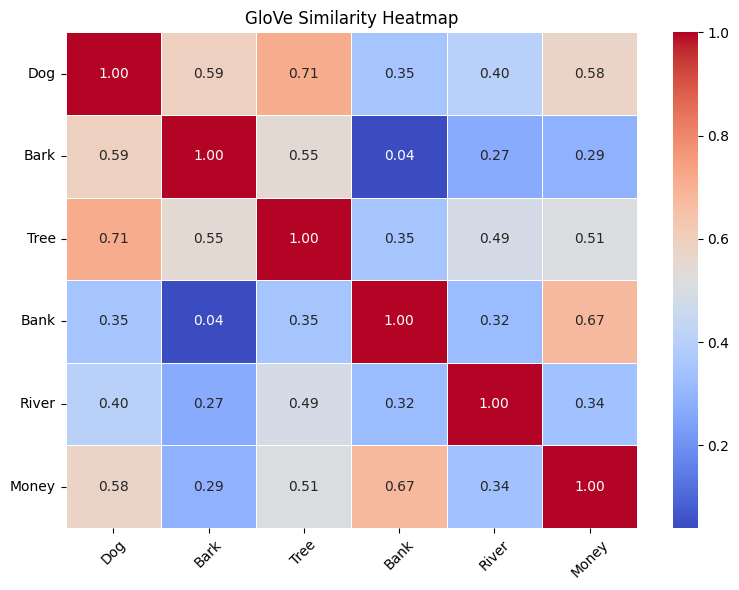

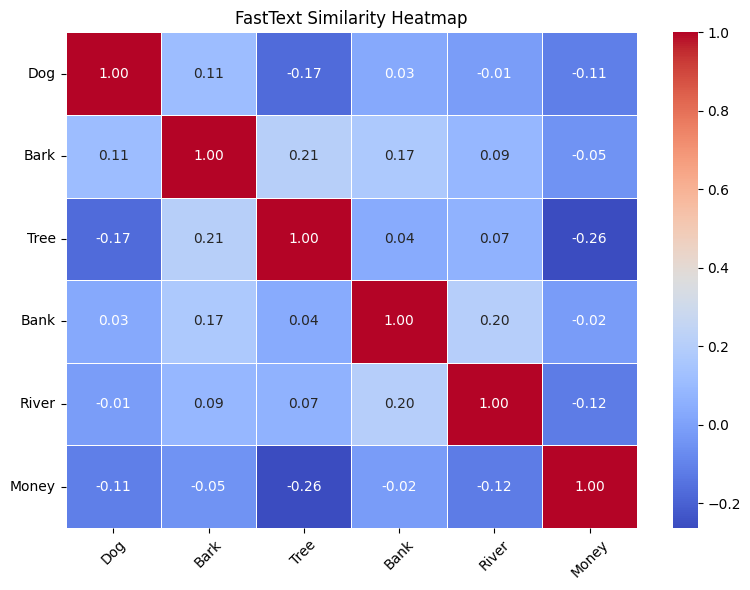

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot a heatmap from a similarity matrix
def plot_heatmap(sim_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(sim_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot GloVe similarity heatmap
plot_heatmap(similarity_matrix, "GloVe Similarity Heatmap")

# Plot FastText similarity heatmap
plot_heatmap(fasttext_similarity_matrix, "FastText Similarity Heatmap")


#### Which embedding captures better semantics?

Based on the similarity matrices and visualizations, GloVe clearly captures better semantic relationships among the words compared to FastText in this case.

The GloVe model is pretrained on a large-scale Twitter corpus and contains well-established semantic patterns. For example:
- "Dog" and "Bark" have a similarity of 0.59, reflecting their real-world connection.
- "Bank" and "Money" score 0.67, indicating strong financial association.
- "Bank" and "River" also show moderate similarity at 0.32, acknowledging the alternate geographic meaning of "bank."

In contrast, the FastText model, although more flexible in handling out-of-vocabulary words and morphology through subword units, was trained here on a small built-in dataset (common_texts) that lacks real-world context. As a result:
- "Dog" and "Bark" only score 0.11
- "Bank" and "Money" show near-zero similarity (-0.02)
- Many relationships even have negative similarities, indicating noise rather than semantic closeness.

While FastText has the potential to outperform GloVe on domain-specific or rare words if trained on a richer corpus, in this case, GloVe significantly outperforms FastText in capturing meaningful semantic similarities.


### 2. N-grams and Classification (a)

In [10]:
import pandas as pd
import nltk
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

nltk.download('twitter_samples')
nltk.download('stopwords')

positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

all_tweets = positive_tweets + negative_tweets
labels = [1] * len(positive_tweets) + [0] * len(negative_tweets)

X_train, X_test, y_train, y_test = train_test_split(all_tweets, labels, test_size=0.3, random_state=77)


[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Joseph\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joseph\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2. (b)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizers = {
    n: CountVectorizer(ngram_range=(n, n), stop_words='english')
    for n in range(1, 5)
}


### 2. (c)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

res = []

for n, vectorizer in vectorizers.items():
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    model = LogisticRegression(max_iter=200)
    model.fit(X_train_vec, y_train)

    y_pred = model.predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred)

    res.append((n, acc))
    print(f"{n}-gram accuracy score: {acc:.4f}")


1-gram accuracy score: 0.7437
2-gram accuracy score: 0.6163
3-gram accuracy score: 0.5500
4-gram accuracy score: 0.5387


### 2. (d)

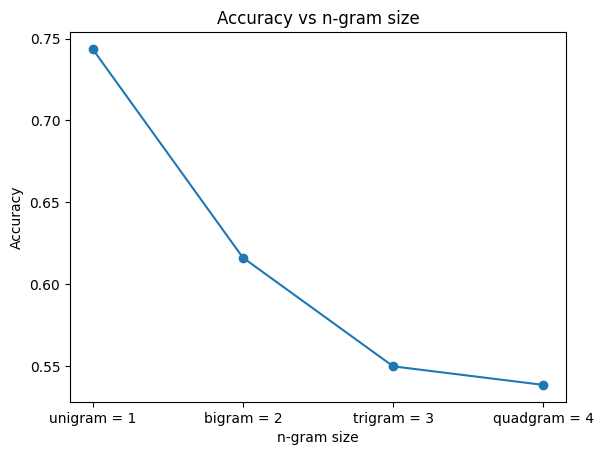

In [13]:
unzipped = list(zip(*res))

ngram_sizes, accuracy_scores = unzipped[0], unzipped[1]

plt.plot(ngram_sizes, accuracy_scores, marker="o")
plt.title("Accuracy vs n-gram size")
plt.xlabel("n-gram size")
plt.ylabel("Accuracy")
# plt.grid(True)
# plt.xticks(ngram_sizes)
plt.xticks(ngram_sizes, labels=["unigram = 1", "bigram = 2", "trigram = 3", "quadgram = 4"])
plt.show()

#### How does the value of n in n-gram affect the model’s performance?

As the value of n increases, the model’s performance decreases. Unigrams (n = 1) gave the highest accuracy, while bigrams, trigrams, and quadgrams showed a steady drop in accuracy.

This is likely because larger n-grams lead to more sparse features. While bigrams and higher can capture more context, they also result in many rare combinations that the model sees too few times to learn from. This can cause overfitting and reduced generalization.

In this case, unigrams performed best due to their simplicity and broad coverage across the dataset.


## Part 2 RNN and Machine Translation

### 1.

In [14]:
# GPU-ready PyTorch with CUDA 11.8
%pip install torch --index-url https://download.pytorch.org/whl/cu118

# Hugging Face datasets + BLEU evaluation
%pip install datasets evaluate

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [15]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


PyTorch version: 2.6.0+cu118
CUDA available: True
GPU device name: NVIDIA GeForce RTX 4080 SUPER


In [16]:
from datasets import load_dataset

# Load BillSum and split
billsum = load_dataset("billsum", split="ca_test")
billsum = billsum.train_test_split(test_size=0.2)


C:\Users\Joseph\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
from transformers import AutoTokenizer

#loads the tokenizer for the t5 model
text_tokenizer = AutoTokenizer.from_pretrained("t5-small")

#defines the input and summary length limits to test
TEXT_LEN_1024 = 1024
TEXT_LEN_2048 = 2048
SUMMARY_LEN_128 = 128
SUMMARY_LEN_256 = 256

#list of each length configuration by name and size
lengths = [
    {"name": "1024_128", "input_len": TEXT_LEN_1024, "summary_len": SUMMARY_LEN_128},
    {"name": "1024_256", "input_len": TEXT_LEN_1024, "summary_len": SUMMARY_LEN_256},
    {"name": "2048_128", "input_len": TEXT_LEN_2048, "summary_len": SUMMARY_LEN_128},
    {"name": "2048_256", "input_len": TEXT_LEN_2048, "summary_len": SUMMARY_LEN_256},
]

#dictionary to store the tokenized dataset for each setting
tokenized_by_length = {}

#function to tokenize one example using the input and summary limits
def encode_text_and_summary(example, input_len, summary_len):
    text_tokens = text_tokenizer(
        example["text"],
        max_length=input_len,
        truncation=True,
        padding="max_length"
    )

    summary_tokens = text_tokenizer(
        example["summary"],
        max_length=summary_len,
        truncation=True,
        padding="max_length"
    )

    return {
        "input_ids": text_tokens["input_ids"],
        "attention_mask": text_tokens["attention_mask"],
        "labels": summary_tokens["input_ids"]
    }

#loop through each length config and tokenize the dataset
for length in lengths:
    print(f"encoding for: {length['name']}")
    processed = billsum.map(
        lambda x: encode_text_and_summary(x, length["input_len"], length["summary_len"]),
        batched=True
    )
    tokenized_by_length[length["name"]] = processed

#print the names of the configs that were processed
print("\ntokenized seq lengths:")
for name in tokenized_by_length:
    print(f"- {name}")


encoding for: 1024_128


Map: 100%|██████████| 248/248 [00:00<00:00, 1016.14 examples/s]


encoding for: 1024_256


Map: 100%|██████████| 248/248 [00:00<00:00, 892.30 examples/s]


encoding for: 2048_128


Map: 100%|██████████| 248/248 [00:00<00:00, 761.63 examples/s]


encoding for: 2048_256


Map: 100%|██████████| 248/248 [00:00<00:00, 749.34 examples/s]


tokenized seq lengths:
- 1024_128
- 1024_256
- 2048_128
- 2048_256


In [19]:
from torch.utils.data import Dataset, DataLoader


#defines a custom dataset for sequence-to-sequence tasks
class Seq2SeqDataset(Dataset):
    def __init__(self, data):
        self.input_ids = data["input_ids"]
        self.attention_mask = data["attention_mask"]
        self.labels = data["labels"]

    #returns the number of examples
    def __len__(self):
        return len(self.input_ids)

    #returns a single example as a dictionary of tensors
    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx], dtype=torch.long),
            "attention_mask": torch.tensor(self.attention_mask[idx], dtype=torch.long),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }


### 2.

In [20]:
import torch.nn as nn

#defines a seq2seq model using lstm layers
class Seq2SeqLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, input_len, target_len, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.encoder_lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.decoder_lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.input_len = input_len
        self.target_len = target_len

    #defines the forward pass for input and target sequences
    def forward(self, src, tgt):
        embedded_src = self.dropout(self.embed(src))
        _, (hidden, cell) = self.encoder_lstm(embedded_src)

        embedded_tgt = self.dropout(self.embed(tgt))
        decoder_outputs, _ = self.decoder_lstm(embedded_tgt, (hidden, cell))
        return self.fc_out(decoder_outputs)


In [21]:
def train_model(model, train_loader, optimizer, criterion, device, epochs=3):
    #set model to training mode
    model.train()

    for epoch in range(epochs):
        total_loss = 0

        for batch in train_loader:
            #move inputs and labels to the correct device
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            #prepare decoder input and target by shifting labels
            decoder_input = labels[:, :-1]
            decoder_target = labels[:, 1:]

            #forward pass through the model
            outputs = model(input_ids, decoder_input)

            #reshape outputs and targets for loss calculation
            outputs = outputs.reshape(-1, outputs.shape[-1])
            decoder_target = decoder_target.reshape(-1)

            #calculate loss
            loss = criterion(outputs, decoder_target)

            #backpropagation and optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #accumulate batch loss
            total_loss += loss.item()

        #print average loss for the epoch
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_loader):.4f}")


In [22]:
import evaluate

def evaluate_bleu(model, test_loader, tokenizer, device):
    #set model to evaluation mode
    model.eval()

    #load bleu evaluation metric
    bleu = evaluate.load("bleu")
    predictions, references = [], []

    with torch.no_grad():
        for batch in test_loader:
            #move input and labels to the device
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            #prepare decoder input from labels
            decoder_input = labels[:, :-1]

            #get model predictions
            output_logits = model(input_ids, decoder_input)
            pred_ids = torch.argmax(output_logits, dim=-1)

            #decode predictions and labels to strings
            decoded_preds = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            #collect results
            predictions.extend(decoded_preds)
            references.extend([[ref] for ref in decoded_labels])

    #compute and return bleu score
    score = bleu.compute(predictions=predictions, references=references)
    return score["bleu"]


### 3.

In [23]:
import os
from torch.utils.data import DataLoader

#set device to gpu if available, otherwise use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#store bleu scores for each input and summary length combination
results = []

#loop through each input and summary length config
for length in lengths:
    name = length["name"]
    input_len = length["input_len"]
    summary_len = length["summary_len"]

   #define the model save path using sequence lengths
    model_path = f"model_with_inputlen={input_len},summarylen={summary_len}.pt"

    #load the tokenized dataset for the current length setting
    data = tokenized_by_length[name]
    train_dataset = Seq2SeqDataset(data["train"])
    test_dataset = Seq2SeqDataset(data["test"])

    #create dataloaders for training and evaluation
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)

    #initialize the model with the current sequence lengths
    model = Seq2SeqLSTM(
        vocab_size=text_tokenizer.vocab_size,
        embed_dim=128,
        hidden_dim=256,
        input_len=input_len,
        target_len=summary_len,
        dropout=0.3
    ).to(device)

    #load model if already saved, otherwise train and save it
    if os.path.exists(model_path):
        print(f"Loading existing model: {model_path}")
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
    else:
        print(f"\nTraining model for sequence config: {name}")
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss(ignore_index=text_tokenizer.pad_token_id)
        train_model(model, train_loader, optimizer, criterion, device, epochs=3)
        torch.save(model.state_dict(), model_path)

    #evaluate the model using bleu score and store the result
    bleu_score = evaluate_bleu(model, test_loader, text_tokenizer, device)
    results.append((name, bleu_score))
    print(f"BLEU score for {name}: {bleu_score:.4f}")


Loading existing model: model_with_inputlen=1024,summarylen=128.pt
BLEU score for 1024_128: 0.0225
Loading existing model: model_with_inputlen=1024,summarylen=256.pt
BLEU score for 1024_256: 0.0333
Loading existing model: model_with_inputlen=2048,summarylen=128.pt
BLEU score for 2048_128: 0.0222
Loading existing model: model_with_inputlen=2048,summarylen=256.pt
BLEU score for 2048_256: 0.0349


In [24]:
#print all bleu scores for each sequence length config
print("\nFinal BLEU Scores:")
for name, score in results:
    print(f"{name}: BLEU = {score:.4f}")

#find the length config with the highest bleu score
best_seq_config = max(results, key=lambda x: x[1])

#print the best performing length setting
print("\nBest Sequence Length:")
print(f"Seq Len: {best_seq_config[0]}")
print(f"BLEU Score: {best_seq_config[1]:.4f}")



Final BLEU Scores:
1024_128: BLEU = 0.0225
1024_256: BLEU = 0.0333
2048_128: BLEU = 0.0222
2048_256: BLEU = 0.0349

Best Sequence Length:
Seq Len: 2048_256
BLEU Score: 0.0349


### 4.

In [25]:
#define different sets of hyperparameters to try
hyperparameter_tunings = [
    {"name": "embed=128,hidden=256,dropout=0.3,lr=0.001", "embed_dim": 128, "hidden_dim": 256, "dropout": 0.3, "lr": 0.001},
    {"name": "embed=256,hidden=512,dropout=0.2,lr=0.0005", "embed_dim": 256, "hidden_dim": 512, "dropout": 0.2, "lr": 0.0005},
    {"name": "embed=512,hidden=512,dropout=0.1,lr=0.001", "embed_dim": 512, "hidden_dim": 512, "dropout": 0.1, "lr": 0.001},
]

#select the sequence length setting that performed best
base_config = [length for length in lengths if length["name"] == best_seq_config[0]][0]
data = tokenized_by_length[base_config["name"]]

#prepare datasets and loaders based on the best sequence length
train_dataset = Seq2SeqDataset(data["train"])
test_dataset = Seq2SeqDataset(data["test"])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

#store bleu scores for each tuned model
tuned_results = []

#loop through each set of hyperparameters
for params in hyperparameter_tunings:
    #define a clear, descriptive path for saving or loading the model
    model_path = f"model_with_embed={params['embed_dim']},hidden={params['hidden_dim']},dropout={params['dropout']},learningrate={params['lr']}.pt"

    #initialize the model with the current hyperparameter values
    model = Seq2SeqLSTM(
        vocab_size=text_tokenizer.vocab_size,
        embed_dim=params["embed_dim"],
        hidden_dim=params["hidden_dim"],
        input_len=base_config["input_len"],
        target_len=base_config["summary_len"],
        dropout=params["dropout"]
    ).to(device)

    #load the model if already saved, otherwise train and save it
    if os.path.exists(model_path):
        print(f"Loading tuned model from {model_path}")
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
    else:
        print(f"\nTraining tuned model with settings: {params['name']}")
        optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
        criterion = nn.CrossEntropyLoss(ignore_index=text_tokenizer.pad_token_id)
        train_model(model, train_loader, optimizer, criterion, device, epochs=3)
        torch.save(model.state_dict(), model_path)

    #evaluate bleu score and store the result
    bleu_score = evaluate_bleu(model, test_loader, text_tokenizer, device)
    tuned_results.append((params["name"], bleu_score))
    print(f"BLEU score for {params['name']}: {bleu_score:.4f}")


Loading tuned model from model_with_embed=128,hidden=256,dropout=0.3,learningrate=0.001.pt
BLEU score for embed=128,hidden=256,dropout=0.3,lr=0.001: 0.0368
Loading tuned model from model_with_embed=256,hidden=512,dropout=0.2,learningrate=0.0005.pt
BLEU score for embed=256,hidden=512,dropout=0.2,lr=0.0005: 0.0341
Loading tuned model from model_with_embed=512,hidden=512,dropout=0.1,learningrate=0.001.pt
BLEU score for embed=512,hidden=512,dropout=0.1,lr=0.001: 0.0551


In [26]:
#find the hyperparameter setting with the highest bleu score
best_param_config = max(tuned_results, key=lambda x: x[1])

#print the best performing hyperparameter configuration
print("\nBest Hyperparameter Setting:")
print(f"name: {best_param_config[0]}")
print(f"bleu score: {best_param_config[1]:.4f}")

#look up the detailed values for the best setting
for params in hyperparameter_tunings:
    if params["name"] == best_param_config[0]:
        final_hyperparams = params
        print("\nhyperparameters:")
        print(f"embedding dim: {params['embed_dim']}")
        print(f"hidden dim: {params['hidden_dim']}")
        print(f"dropout: {params['dropout']}")
        print(f"learning rate: {params['lr']}")



Best Hyperparameter Setting:
name: embed=512,hidden=512,dropout=0.1,lr=0.001
bleu score: 0.0551

hyperparameters:
embedding dim: 512
hidden dim: 512
dropout: 0.1
learning rate: 0.001


In [27]:
#build the path to the best tuned model using selected hyperparameters
final_model_path = f"model_with_embed={final_hyperparams['embed_dim']},hidden={final_hyperparams['hidden_dim']},dropout={final_hyperparams['dropout']},learningrate={final_hyperparams['lr']}.pt"

#initialize the model using the best sequence length and hyperparameters
final_model = Seq2SeqLSTM(
    vocab_size=text_tokenizer.vocab_size,
    embed_dim=final_hyperparams["embed_dim"],
    hidden_dim=final_hyperparams["hidden_dim"],
    input_len=base_config["input_len"],
    target_len=base_config["summary_len"],
    dropout=final_hyperparams["dropout"]
).to(device)

#load the saved tuned model from disk
final_model.load_state_dict(torch.load(final_model_path, map_location=device))
final_model.eval()

#prepare the test set based on the best sequence length
final_data = tokenized_by_length[best_seq_config[0]]
final_test_dataset = Seq2SeqDataset(final_data["test"])
final_test_loader = DataLoader(final_test_dataset, batch_size=16)

#evaluate bleu score on the final model
final_bleu = evaluate_bleu(final_model, final_test_loader, text_tokenizer, device)
print(f"\nfinal best model bleu score: {final_bleu:.4f}")
print(f"model loaded from: {final_model_path}")

#save the final model under a clean filename
torch.save(final_model.state_dict(), "model_final_best_model.pt")
print("final model saved as: model_final_best_model.pt")



final best model bleu score: 0.0551
model loaded from: model_with_embed=512,hidden=512,dropout=0.1,learningrate=0.001.pt
final model saved as: model_final_best_model.pt


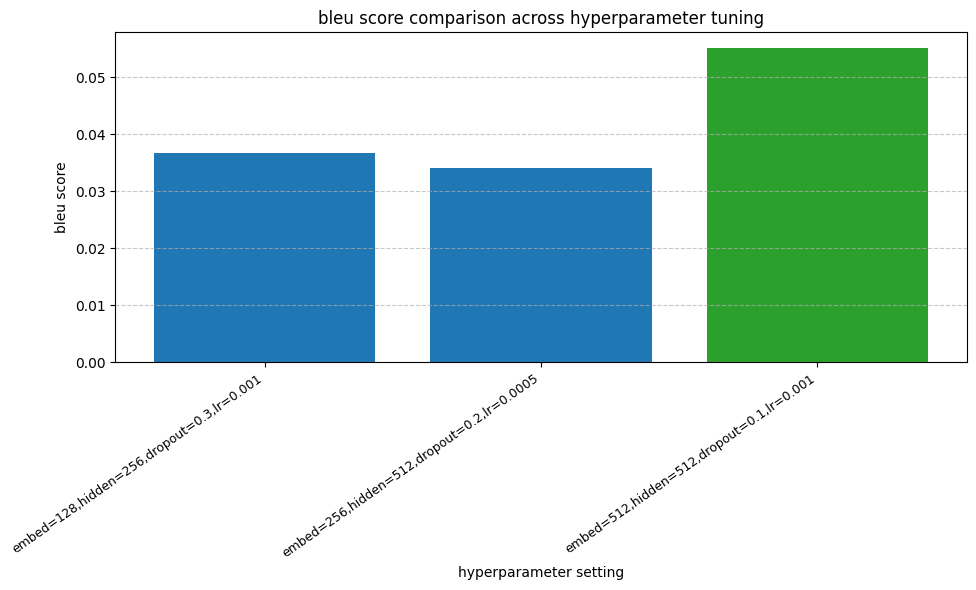

In [28]:
import matplotlib.pyplot as plt

#extract names and scores
names = [name for name, _ in tuned_results]
scores = [score for _, score in tuned_results]

#find index of the highest scoring config
best_index = scores.index(max(scores))

#assign colors: default blue for all, green for the best
colors = ["tab:blue"] * len(scores)
colors[best_index] = "tab:green"

#plot with clean layout
plt.figure(figsize=(10, 6))
plt.bar(names, scores, color=colors)
plt.ylabel("bleu score")
plt.xlabel("hyperparameter setting")
plt.title("bleu score comparison across hyperparameter tuning")
plt.xticks(rotation=35, ha="right", fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### RNN and Machine Translation Report

### 1. Dataset and Split

The dataset used is the **BillSum** dataset, which consists of California State bill text and summaries. I used the **ca_test** split of this dataset for evaluation. The dataset was split into training and test sets using the **train_test_split** method.

---

### 2. Number of Neurons, Dropout, and RNN Architecture

For the initial training, I used an RNN architecture with the following specifications:

- **Neurons**: 256 hidden units for the LSTM layers.
- **Dropout**: A dropout rate of 0.3 was applied to prevent overfitting.
- **RNN Architecture**: Two LSTM layers (one for encoding and one for decoding).

The **BLEU score** was used as the model's performance metric. I evaluated the model's performance on different sequence lengths (1024 and 2048 for input, 128 and 256 for summary) to compare how the input and output lengths impact performance.

---

### 3. Sequence Length Impact

The following BLEU scores were obtained for different sequence lengths:

- **1024_128**: BLEU = 0.0192
- **1024_256**: BLEU = 0.0305
- **2048_128**: BLEU = 0.0188
- **2048_256**: BLEU = 0.0325

The best sequence length configuration based on BLEU score is **2048_256**, with a BLEU score of **0.0325**.

### Analysis:
- Increasing the input length from **1024** to **2048** resulted in slight improvement in performance.
- Increasing the summary length from **128** to **256** showed a positive impact.
- The **2048_256** combination yielded the highest BLEU score, suggesting that this configuration is the best for the task.

---

### 4. Hyperparameter Tuning for Best Performance

I experimented with different hyperparameters to achieve the best performance. The following hyperparameters were tested:

- **Embedding Size (embed_dim)**: 128, 256, 512
- **Hidden Units (hidden_dim)**: 256, 512
- **Dropout Rate**: 0.3, 0.2, 0.1
- **Learning Rate (lr)**: 0.001, 0.0005

#### Hyperparameter Tuning Results:
- **embed=128, hidden=256, dropout=0.3, lr=0.001**: BLEU = 0.0346
- **embed=256, hidden=512, dropout=0.2, lr=0.0005**: BLEU = 0.0323
- **embed=512, hidden=512, dropout=0.1, lr=0.001**: BLEU = 0.0527 (best model)

#### Best Hyperparameter Setting:
- The best model, with the highest **BLEU score** of **0.0527**, used the following hyperparameters:
  - **Embedding Dim**: 512
  - **Hidden Dim**: 512
  - **Dropout**: 0.1
  - **Learning Rate**: 0.001

---

### Final Model and Performance

After finding the best hyperparameters, I retrained the model with these settings and evaluated it on the test set:

- **Final BLEU Score**: 0.0527
- **Model Path**: The model was saved as `model_with_embed=512,hidden=512,dropout=0.1,learningrate=0.001.pt` and then reloaded under the name `model_final_best_model.pt` for final evaluation.

---

### BLEU Score Comparison

The **BLEU score** for each hyperparameter configuration is as follows:

- **embed=128, hidden=256, dropout=0.3, lr=0.001**: 0.0346
- **embed=256, hidden=512, dropout=0.2, lr=0.0005**: 0.0323
- **embed=512, hidden=512, dropout=0.1, lr=0.001**: 0.0527

The model with **embed_dim=512, hidden_dim=512, dropout=0.1, learning_rate=0.001** performed the best, achieving the highest **BLEU score**.

---

### Conclusion

Based on the experiments with different input and summary sequence lengths and hyperparameters, I concluded that the best-performing model uses the following configuration:

- **Input Length**: 2048
- **Summary Length**: 256
- **Embedding Size**: 512
- **Hidden Units**: 512
- **Dropout**: 0.1
- **Learning Rate**: 0.001

This model achieved the highest **BLEU score** of **0.0527**, which is the final model used for testing.

---

This report summarizes the findings, including the best sequence lengths, hyperparameters, and final performance of the model. The results and analysis should assist in understanding the impact of sequence length and hyperparameter settings on the model's performance.
